
# Assignment 3: Deep Learning Classifier for The Human Freedom Index

This notebook contains a set of exercises that will guide you through the different steps of this assignment. Solutions need to be code-based, _i.e._ hard-coded or manually computed results will not be accepted. Remember to write your solutions to each exercise in the dedicated cells and to not modify the test cells. When you are done completing all the exercises submit this same notebook back to moodle in **.ipynb** format.

<div class="alert alert-success">

The <a href="https://www.cato.org/human-freedom-index/2021 ">Human Freedom Index</a> measures economic freedoms such as the freedom to trade or to use sound money, and it captures the degree to which people are free to enjoy the major freedoms often referred to as civil liberties—freedom of speech, religion, association, and assembly— in the countries in the survey. In addition, it includes indicators on rule of law, crime and violence, freedom of movement, and legal discrimination against same-sex relationships. We also include nine variables pertaining to women-specific freedoms that are found in various categories of the index.

<u>Citation</u>

Ian Vásquez, Fred McMahon, Ryan Murphy, and Guillermina Sutter Schneider, The Human Freedom Index 2021: A Global Measurement of Personal, Civil, and Economic Freedom (Washington: Cato Institute and the Fraser Institute, 2021).
    
</div>


<div class="alert alert-danger"><b>Submission deadline:</b> Sunday, February 26th, 23:55</div>


In [67]:
import numpy as np
import pandas as pd

<div class="alert alert-info"><b>Exercise 1</b>

Load the Human Freedom Index data from the link: https://github.com/jnin/information-systems/raw/main/data/hfi_cc_2021.csv in a DataFrame called ```df```. The following columns are redundant and should be dropped:
* ```year```
* ```ISO```
* ```countries```
* All columns containing the word ```rank``` 
* All columns containing the word ```score```
    
Then store the independent variables in a DataFrame called ```X``` and the dependent variable (```hf_quartile```) in a DataFrame called ```y```. Finally, split them into separate training and test sets with the relative size of 0.75 and 0.25. Store the training and tests feature matrix in variables called ```X_train``` and ```X_test```, and the training and test label arrays as ```y_train``` and ```y_test```.

<br><i>[1 point]</i>
</div>
<div class="alert alert-warning">
Do not download the dataset. Instead, read the data directly from the provided link
</div>

We will start by importing all Scikit-learn modules that may be necessary, as well as plotting libraries and warning hiders actions. We will import Keras libraries starting from exercise 5, so that it is clearer what we are exactly using.

In [77]:
#Scikit-learn

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

# Plotting libraries

from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

# And a warning hider to make our code cleaner.

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# This code iis necessary, as we will be able to skip many long warnings from Keras
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Now, we download the CSV, and drop the aforementioned columns. We will then take a look at the head of the dataframe to make sure we haven't missed anything and everything is as expected. Finally, we split outright for the rest of the exercise.

In [78]:
#We download the CSV from the link

df=pd.read_csv("https://github.com/jnin/information-systems/raw/main/data/hfi_cc_2021.csv")

#We drop the aforementioned columns, as well as target feature NaN's for subsequent models to handle it

df.drop(["year", "ISO", "countries"], axis=1, inplace=True)
df.drop(df.filter(regex='score|rank').columns, axis=1, inplace=True)
df.dropna(subset=["hf_quartile"], inplace=True)

print(f' The number of columns dropped is {125-df.shape[1]}, we have now {df.shape[1]} features and {df.shape[0]} instances.')

 The number of columns dropped is 11, we have now 114 features and 1867 instances.


In [79]:
df.head()

,region,hf_quartile,pf_rol_procedural,pf_rol_civil,pf_rol_criminal,pf_rol,pf_ss_homicide,pf_ss_disappearances_disap,pf_ss_disappearances_violent,pf_ss_disappearances_organized,...,ef_regulation_labor_conscription,ef_regulation_labor,ef_regulation_business_adm,ef_regulation_business_bureaucracy,ef_regulation_business_start,ef_regulation_business_bribes,ef_regulation_business_licensing,ef_regulation_business_compliance,ef_regulation_business,ef_regulation
0,Eastern Europe,2.0,5.97,4.76,4.26,5.00,9.33,10.0,10.00,7.5,...,10.0,6.72,5.65,6.67,9.74,6.24,5.62,7.18,6.85,7.70
1,Middle East & North Africa,4.0,5.21,5.64,4.35,5.07,9.60,10.0,10.00,5.0,...,3.0,5.65,4.22,2.22,9.31,2.58,8.77,7.03,5.69,5.84
2,Sub-Saharan Africa,4.0,2.72,4.43,3.60,3.58,8.59,10.0,9.57,7.5,...,0.0,5.34,2.94,2.44,8.73,4.70,7.92,6.78,5.59,5.97
3,Latin America & the Caribbean,2.0,6.83,5.94,4.35,5.71,8.46,5.0,10.00,7.5,...,10.0,5.12,2.71,5.78,9.58,6.53,5.73,6.51,6.14,5.99
4,Caucasus & Central Asia,1.0,NaN,NaN,NaN,4.98,9.51,10.0,10.00,7.5,...,0.0,6.46,5.17,5.56,9.86,6.96,9.30,7.04,7.32,7.82


In [80]:
# Target and features array
X=df.drop("hf_quartile", axis=1)
y=df["hf_quartile"]

# Make the split
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25, train_size=0.75)

In [81]:
# LEAVE BLANK

In [82]:
# LEAVE BLANK

In [83]:
## LEAVE BLANK

In [84]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 2</b>

Write the code to create a ```Pipeline``` consisting of a ```SimpleImputer``` with the most frequent strategy, a ```OneHotEncoder``` for the categorical variables, a standard scaler, and a ```MLPClassifier``` model specifying ```max_iter``` equal to 250. Store the resulting pipeline in a variable called ```pipe```.   

<br><i>[1.5 points]</i>
</div>

We make sure again of all the types of categorical features. Then, we create our pipeliine with the sepecified steps and parameters. We define a ```ColumnTransformer``` to isolate the One Hot Encoding of ```region```, using the ```remainder``` argument to passthrough all the other variables.

In [85]:
# Categorical features
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Numerical features
num_cols = df.select_dtypes(include=['float', 'int']).columns.tolist()

print(f'The number of categorical features is {len(cat_cols)}, and this is {cat_cols}.')

The number of categorical features is 1, and this is ['region'].


In [86]:
# We specify first the ColumnTransformer for "region"

transformer=ColumnTransformer([("onehot", OneHotEncoder(sparse=False), [X_train.columns.get_loc('region')])], 
                             remainder="passthrough")

#We instantate all other pipeline transformations

imputer=SimpleImputer(strategy="most_frequent")
scaler=StandardScaler()
mlp=MLPClassifier(max_iter=250)

#We define pipeline inner steps and instantiate our pipeline

pipe_steps=[("imputer", imputer), ("transformer", transformer),
            ("scaler", scaler), ("mlp", mlp)]

pipe=Pipeline(pipe_steps)

In [87]:
# LEAVE BLANK

In [88]:
# LEAVE BLANK

In [89]:
# LEAVE BLANK

In [90]:
# LEAVE BLANK

In [91]:
# LEAVE BLANK

In [92]:
# LEAVE BLANK

In [93]:
# LEAVE BLANK

In [94]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 3</b>
    
Write the code to create a GridSearchCV object called ```grid``` and fit it. The grid search object must contain the pipeline created in the previous exercise. Then, consider the following hyperparameters:
* ```learning_rate_init``` : [0.001, 0.0001]
* ```alpha``` : [0.0001,1]

Finally, store the best score (accuracy) of the training phase in a variable called ```training_score```.
<br><i>[1.5 point]</i>
</div>

We will use ```cv=5``` (the default, as nothing has been said) inside our ```GridSearchCV```, creating previously our dictionary with the values to hyperparameterize. In this case, we are asked for the average accuracy score of the 5 cross-validations: we will fit our grid with train sets and call ```grid.best_score_``` to have it.

In [95]:
grid_params={"mlp__learning_rate_init": [0.001, 0.0001],
     "mlp__alpha": [0.0001, 1]}

grid=GridSearchCV(pipe, grid_params, cv=5)

grid.fit(X_train, y_train)
print(grid.best_params_)
training_score=grid.best_score_
print(f' This is the cross-validation average accuracy score with GridSearchCV applied:{training_score.round(6)}')

{'mlp__alpha': 0.0001, 'mlp__learning_rate_init': 0.001}
 This is the cross-validation average accuracy score with GridSearchCV applied:0.947143


In [96]:
# LEAVE BLANK

In [97]:
# LEAVE BLANK

In [98]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 4</b>
    
Write the code to compute the real achieved ```score``` of the previous grid search to check whether your model is doing overfitting or not.
    
<br><i>[1 point]</i>
</div>

Now, we will actually compare the grid resulting best hyperparameterized model with the holdout test set. This is done by calling the best estimators and then calling the score: ```grid.best_estimator_.score(X_test, y_test)```. As a backup, we will provide a picture of the evaluation repeated 50 times for both training sets and holdout test sets, which confirm that overfitting is not that big, and that cross_validation training scores are generally better than holdout test set scores with a bit more confidence.

In [99]:
score=grid.best_estimator_.score(X_test, y_test)
print(f' This is the cross-validation average accuracy score with GridSearchCV applied: {training_score.round(6)}')
print(f' This is the accuracy when compared with the holdout test set: {score.round(6)}')

 This is the cross-validation average accuracy score with GridSearchCV applied: 0.947143
 This is the accuracy when compared with the holdout test set: 0.940043


We carried out a simulation a 50 times of the model so that we can actually validate the acceptable level of overfitting seen with a bit more of confidence. Results are clear, there is little overfitting, with cross-validation tests being on average superior. Therefore, in terms of accuracy, we could say overfitting is acceptable and results make sense.

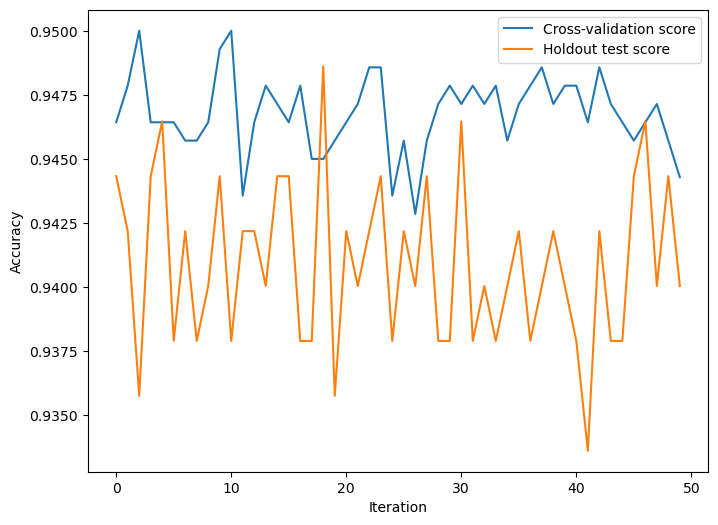

In [100]:
# LEAVE BLANK

In [101]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 5</b>

The previous exercises use the scikit learn MLP classifier. Now create an MLP classifier using the Keras library. You can use any tutorial, website, or documentation for this task. Describe how you preprocessed the dataset, the network architecture used, and any trick you employed in the exercise.
    
<br><i>[5 points]</i>
</div>

We will start by dropping the variables stated at the beginning of the assignment, and take a look at the initial statistics. There, we can see what we saw in previous assignments: some variables are very different in terms of scale and are somehow skewed (seen in differences median vs mean). In this assignment, we will take a more harsh approach on variables included with arguments for it, which should reduce their effect.

In [102]:
df=pd.read_csv("https://github.com/jnin/information-systems/raw/main/data/hfi_cc_2021.csv")

# Dropping the variables stated in Exercise 1

df.drop(["year", "ISO", "countries"], axis=1, inplace=True)
df.drop(df.filter(regex='score|rank').columns, axis=1, inplace=True)
df.dropna(subset=["hf_quartile"], inplace=True)

print(f' The number of columns dropped is {125-df.shape[1]}, we have now {df.shape[1]} features and {df.shape[0]} instances.')

 The number of columns dropped is 11, we have now 114 features and 1867 instances.


In [103]:
#  We take a look at some statistics of the dataframe.
df.describe()

,hf_quartile,pf_rol_procedural,pf_rol_civil,pf_rol_criminal,pf_rol,pf_ss_homicide,pf_ss_disappearances_disap,pf_ss_disappearances_violent,pf_ss_disappearances_organized,pf_ss_disappearances_fatalities,...,ef_regulation_labor_conscription,ef_regulation_labor,ef_regulation_business_adm,ef_regulation_business_bureaucracy,ef_regulation_business_start,ef_regulation_business_bribes,ef_regulation_business_licensing,ef_regulation_business_compliance,ef_regulation_business,ef_regulation
count,1867.000000,1231.000000,1231.000000,1231.000000,1867.000000,1863.000000,1848.000000,1867.000000,1733.000000,1867.000000,...,1864.000000,1863.000000,1732.000000,1825.000000,1857.000000,1833.000000,1836.000000,1853.000000,1863.000000,1867.000000
mean,2.510445,5.530422,5.542453,4.996052,5.208811,7.995346,8.476732,9.334703,6.699365,8.934237,...,6.608369,6.448583,4.017979,5.320734,8.941174,5.843230,7.870626,6.935769,6.509152,7.054874
std,1.119482,2.039849,1.328770,1.635653,1.590487,2.536540,3.059330,2.093452,2.781988,2.633904,...,4.234543,1.389888,1.181790,2.555125,1.136564,2.382982,1.623539,2.028033,1.270069,1.034680
min,1.000000,1.000000,1.890000,1.290000,1.510000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.100000,0.000000,0.000000,0.780000,0.000000,0.000000,0.000000,1.980000,2.500000
25%,2.000000,4.030000,4.560000,3.720000,3.990000,7.430000,10.000000,10.000000,5.000000,9.660000,...,3.000000,5.430000,3.220000,3.440000,8.660000,4.020000,7.150000,6.330000,5.710000,6.460000
50%,3.000000,5.160000,5.340000,4.550000,4.870000,9.060000,10.000000,10.000000,7.500000,10.000000,...,10.000000,6.480000,3.985000,5.330000,9.340000,5.860000,8.240000,7.430000,6.580000,7.140000
75%,4.000000,7.285000,6.390000,6.185000,6.435000,9.620000,10.000000,10.000000,10.000000,10.000000,...,10.000000,7.550000,4.710000,7.330000,9.660000,7.670000,9.070000,8.240000,7.360000,7.755000
max,4.000000,9.670000,8.770000,8.720000,8.830000,9.950000,10.000000,10.000000,10.000000,10.000000,...,10.000000,9.730000,7.690000,10.000000,9.980000,10.000000,10.000000,9.930000,9.450000,9.430000


We can visualize the aforementioned skewness of some variables by a simple comparison across means and medians.

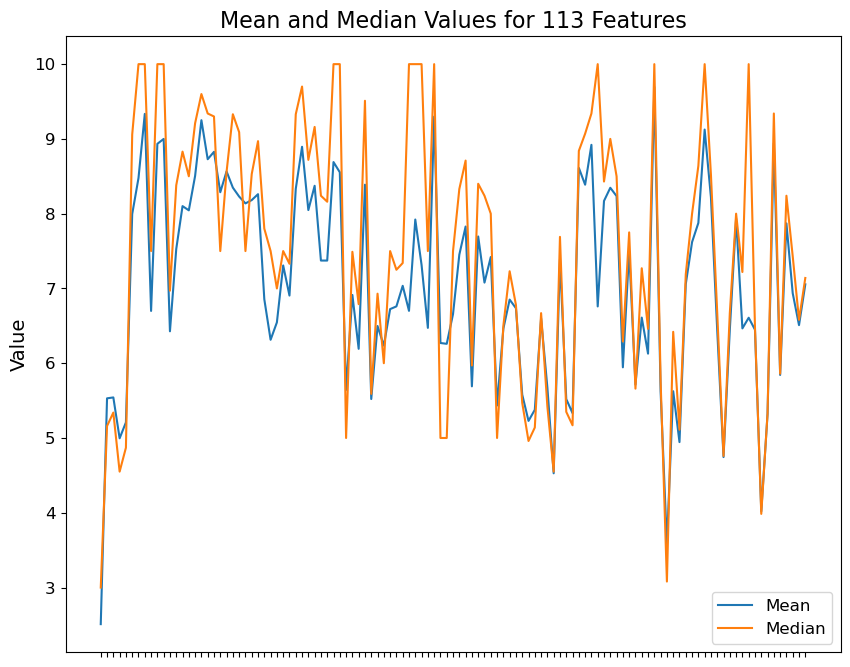

In [104]:
import pandas as pd
import matplotlib.pyplot as plt

# Geting the data
summary = df.describe().iloc[1:, :].T
mean_vals = summary['mean']
median_vals = summary['50%']

# Line plot creation
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(mean_vals, label='Mean')
ax.plot(median_vals, label='Median')

# Formatting
ax.set_title("Mean and Median Values for 113 Features", fontsize=16)
ax.set_ylabel("Value", fontsize=14)
ax.set_xticklabels([])
ax.tick_params(axis='y', labelsize=12)
ax.legend(fontsize=12)
plt.show()

# Overall Exercise 5 structure #

We will break down or Exercise 5 in 4 building blocks:

1. **Variables cleaning: target feature perspective**

   1. Ensuring a balanced distribution without minority classes
   2. Non-explainable features removal (<0.5 Pearson score)
   

2. **Keras needed changes: ```float32```types and ```region``` one hot encoding**


3. **Variables cleaning: features matriix perspective**

   1. Missing values in feature matrix: elimination of variables with too much
   2. Multicollinearity (Pearson >0.95)
   
   
4. **Keras Sequential Network**

   1. Sequential Network with Scikit-learn wrapper
   2. Second model: fine-tuned Sequential Network with GridSearchCV
   3. Conclusions and final comment
   

## 1. Data Cleaning from target feature perspective ##

We will start by cleaning variables from the ```hf_quartile``` perspective. In this case, we will first ensure a balanced distribution of classes and remove from the root variables that are not suffiiciently correlated. 

**Ensuring a balanced distribution without minority classes**

We basically make sure there is no future need to rebalance, move weigths or apply SMOTE methods for the minority class to be correctly spotted and predcted. We see that this perfectly holds.

In [56]:
# Examine y target distribution in more detail. We see there is no unbalance.
print("Total number of instances\n",df["hf_quartile"].value_counts())
print("\nPercentages\n", df["hf_quartile"].value_counts(normalize=True), "\n")

Total number of instances
 4.0    474
3.0    467
2.0    464
1.0    462
Name: hf_quartile, dtype: int64

Percentages
 4.0    0.253883
3.0    0.250134
2.0    0.248527
1.0    0.247456
Name: hf_quartile, dtype: float64 



**Non-explainable features removal**

As seen in other courses, research shows a general trend in ML models stating that a model with few instances generally performs better if we have less features, and the same applies to models with a high number of instances the other way around.

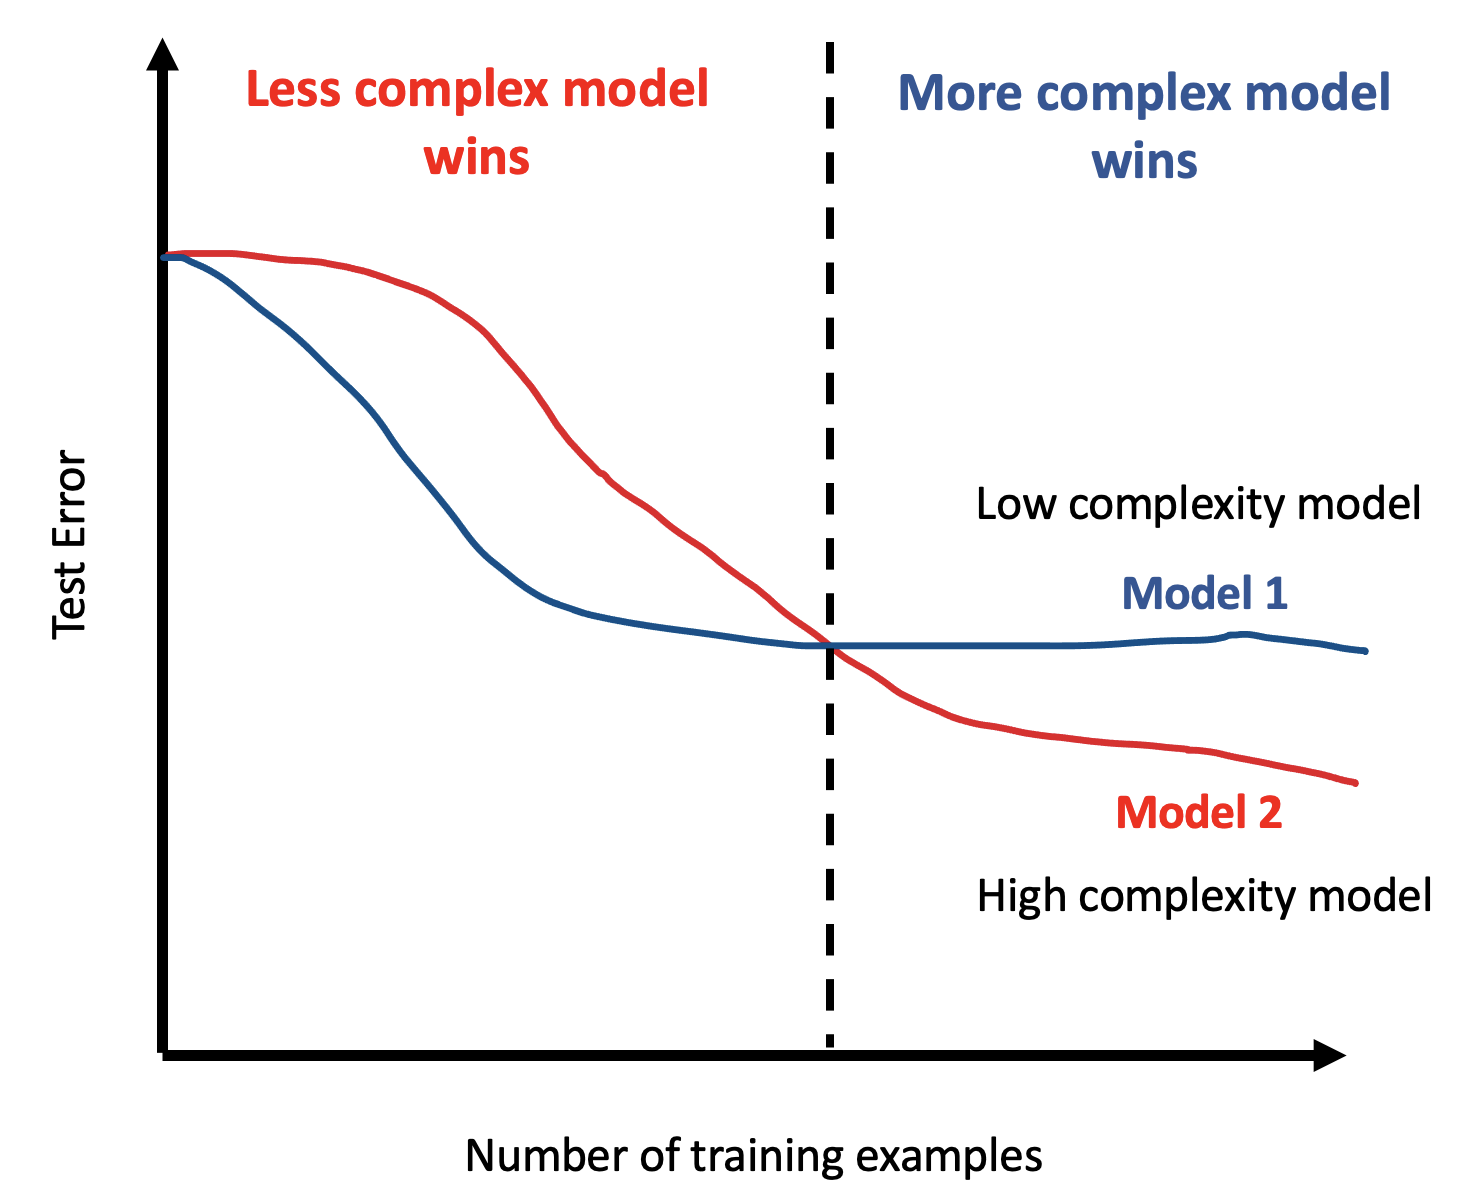

In this case, although a deep neural network for such a problem may not be the best in terms of computational cost, the reduction of features to those that are important may simplify such associated costs. We will remove variables with a correlation <= to 50% with ```hf_quartile```.

In [57]:
# We check y correlation with other features so that we keep only those that are informative.

target_correlations = abs(df.corrwith(df["hf_quartile"]).sort_values())
print(f'\n We will take 0.5 correlation as threshold, with {len(target_correlations[target_correlations>0.50])} variables to keep. \n')
print(target_correlations.head(10), "\n")

#We drop them.

df = df.drop(columns=target_correlations[target_correlations < 0.5].index)
print(f'After first drop of variables that are non-correlated with "hf_quartile", we have a {df.shape} dataset.')


 We will take 0.5 correlation as threshold, with 67 variables to keep. 

pf_rol_procedural               0.858676
pf_assembly_freedom             0.855454
pf_assembly_freedom_house       0.847266
pf_expression_media             0.840668
pf_ss_disappearances_torture    0.817109
pf_expression                   0.814203
pf_expression_freedom           0.807517
pf_movement                     0.806789
pf_expression_harass            0.804240
ef_legal                        0.803870
dtype: float64 

After first drop of variables that are non-correlated with "hf_quartile", we have a (1867, 68) dataset.


## 2. Important changes for Keras: float32 type and one-hot encoding of ```region``` ##

Keras cannot accept ```float64``` variable types, as well as it cannot accept ```uint8``` variables that result from one hot encoding when done inside a pipeline. **Therefore, it is worth stressing that a one-hot-encoding of our ```region``` variable and the transformation to acceptable formats is needed beforehand, as we plan to use a ```Pipeline``` for our model. This is what we will do in this section.**

In [58]:
# We first double check all the different types of variables inside our Pandas dataframe.

df.dtypes.value_counts()

float64    67
object      1
dtype: int64

In order for the encoding of region to be done outside of a Scikit-learn ```Pipeline```, we will use the function ```pd.get_dummies()```, and drop manually the ```region``` column in the resulting concatenated dataframe.

In [59]:
region_dummy=pd.get_dummies(df["region"])
df = pd.concat([df, region_dummy], axis=1)
df.drop("region",axis=1, inplace=True)
df

,hf_quartile,pf_rol_procedural,pf_rol_civil,pf_rol_criminal,pf_rol,pf_ss_disappearances_organized,pf_ss_disappearances_torture,pf_ss_killings,pf_ss_disappearances,pf_movement_vdem_foreign,...,Caucasus & Central Asia,East Asia,Eastern Europe,Latin America & the Caribbean,Middle East & North Africa,North America,Oceania,South Asia,Sub-Saharan Africa,Western Europe
0,2.0,5.97,4.76,4.26,5.00,7.50,8.28,9.72,9.36,9.51,...,0,0,1,0,0,0,0,0,0,0
1,4.0,5.21,5.64,4.35,5.07,5.00,6.40,6.65,8.29,7.03,...,0,0,0,0,1,0,0,0,0,0
2,4.0,2.72,4.43,3.60,3.58,7.50,4.30,7.28,8.34,7.54,...,0,0,0,0,0,0,0,0,1,0
3,2.0,6.83,5.94,4.35,5.71,7.50,7.27,8.43,8.30,8.99,...,0,0,0,1,0,0,0,0,0,0
4,1.0,NaN,NaN,NaN,4.98,7.50,7.66,9.57,9.25,9.43,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1974,1.0,7.03,7.14,5.04,6.40,10.00,8.92,9.81,9.82,9.63,...,0,0,0,1,0,0,0,0,0,0
1975,4.0,3.00,3.78,2.37,3.05,10.00,6.15,7.67,9.11,7.96,...,0,0,0,1,0,0,0,0,0,0
1976,4.0,6.67,4.35,5.69,5.57,10.00,5.11,7.88,8.28,7.13,...,0,0,0,0,0,0,0,1,0,0
1978,3.0,4.80,4.58,3.69,4.36,10.00,5.44,7.11,8.94,9.60,...,0,0,0,0,0,0,0,0,1,0


Then, it is time now that all columns are encoded, to make the changes to acceptable numeric formats. For convenience, all values will be converted to ```float32```.

In [60]:
# We identify columns that are of type 'float64' and 'uint8' (according to Pandas typing scheme)

float_cols = df.select_dtypes(include=['float']).columns
uint_cols = df.select_dtypes(include=['uint8']).columns

print(f'In total, {len(float_cols)} float and {len(uint_cols)} uint8 columns out of {df.shape[1]} features will be changed to float32 for Keras.')

# We convert the selected columns to float32 data type, accepted by Keras.
df[float_cols] = df[float_cols].astype('float32')
df[uint_cols] = df[uint_cols].astype('float32')

df.dtypes.value_counts()

In total, 67 float and 10 uint8 columns out of 77 features will be changed to float32 for Keras.


float32    77
dtype: int64

We can now split our dataset without any further issues!

In [61]:
# We can now split into target array and features matrix without fear of Keras accepted types!

X=df.drop("hf_quartile", axis=1)
y=df["hf_quartile"]

## 3. Data Cleaning in features matrix ##

We will start by removing variables that contain many missing values (>20% of instances), to avoid too much noise with replacement, as keras does not accept NaN. Then, we'll take into account multicollinearity for havng our final X and y datasets ready.

**Missing values in features matrix: elimination of variables with too much**

    1. If missing values are >20%, we drop the column.
    2. If missing values <20%, we impute by "most_frequent", in line with above exercise (done inside the pipe  we will build when creating our keras sequential network).

In [62]:
# We create a dataframe identifying NaN across columns, and sorted for visualization purposes

missing_val = pd.DataFrame({"NaN": X.isna().sum(), "NaN%": (X.isna().sum()) / len(X)})
missing_val.sort_values(by="NaN%", ascending=False).head(10)

,NaN,NaN%
pf_identity_inheritance_daughters,950,0.508838
pf_identity_inheritance_widows,950,0.508838
pf_rol_procedural,636,0.340653
pf_rol_criminal,636,0.340653
pf_rol_civil,636,0.340653
pf_expression_freedom_bti,483,0.258704
pf_assembly_freedom_bti,483,0.258704
ef_legal_military,175,0.093733
pf_ss_disappearances_organized,134,0.071773
ef_government_enterprises,98,0.052491


Then, we make the removal we mentioned of those columns over 20% of NaN.

In [63]:
X=X.drop(columns=missing_val[missing_val["NaN%"] > 0.2].index)
print(f'We remove {len(missing_val[missing_val["NaN%"]>0.2])} variables, going on with a dataframe of {X.shape[1]} features.')

We remove 7 variables, going on with a dataframe of 69 features.


**Multicollinearity**

We will drop features with a pearson score superior to 0.95 (we prefer being conservative, as this would begin to affect loss of information a bit much).

In [64]:
# We select only columns of numeric data types
numeric_columns = X.select_dtypes(include=[np.number])

# We create a correlation matrix
corr_matrix = numeric_columns.corr().abs()

# We select upper triangle of correlation matrix, discarding same variables
upper = corr_matrix.where((np.triu(np.ones(corr_matrix.shape), k=1) + np.tril(np.ones(corr_matrix.shape), k=-1)).astype(bool))

# We find features with correlation greater than 0.9
drop_multic = [column for column in upper.columns if any(upper[column] > 0.95)]

# We drop the features
X.drop(drop_multic, axis=1, inplace=True)

print(f'After the whole data cleaning process, we will start the split with a dataset of {X.shape[0]} rows and {X.shape[1]} columns.')

After the whole data cleaning process, we will start the split with a dataset of 1867 rows and 54 columns.


## Keras Sequential Network (MLP) ##

We will start by creating our first model, with a Scikit-learn wrapper. This will allow us to actually make use of the Scikit-learn structure for Keras. We re-do our split with the data clean, and ensure the distribution of values in the split is reasonable and that we do not need the ```stratify```argument.

In [39]:
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=42, test_size=0.25)

In [40]:
# We check target variable distribution is similar across sets.

# Check train target distribution
print((y_train.value_counts() / len(y_train)) * 100)

# Check test target distribution
print("\n",(y_test.value_counts() / len(y_test)) * 100)

4.0    25.642857
2.0    25.000000
3.0    24.928571
1.0    24.428571
Name: hf_quartile, dtype: float64

 1.0    25.695931
3.0    25.267666
4.0    24.625268
2.0    24.411135
Name: hf_quartile, dtype: float64


**First model: Sequential Network with Scikit-learn wrapper**

We build our model: we put as an input shape 54 in line with the features in ```X```. We will build 2 different layers, both with ```reLU``` activation function. According to Miguel Esteban, Datacamp instructor for Deep Learning with Keras (https://www.linkedin.com/in/mikstevan/), this is a first good default option for any type of function. In this specific case, we created 2 layers, which we assumed as being the most reasonable balance between enhanced accuracy and the computational cost.

In the output layer, we have 4 possible results (the 4 quartiles), and we use ```softmax```as activation function, which ensures all outputs sum up 1 and that a predicted instance can only be part of one output neuron. As a loss function we will use ```categorical_crossentropy``` which apart from being the natural choice  for the multi-class classification problem we are facing here, it also penalizes large confidences in errors and it is computationally efficient. In below cells we will explain in more detail each line of code for our model.

In [41]:
# We first import all subsequent Keras modules we will need

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import History
from keras.utils import to_categorical

### Defining MLP architecture ###

let's define in more detail the code of our sequential network below (MLP).


***keras_model = Sequential()***

The Sequential() function from the Keras API is used to create a sequential model, meaning that layers are added to the model in a linear stack.


***keras_model.add(Dense(neurons1, input_shape=(54,), activation='relu'))***

The first line model.add adds a dense layer with 64 units to the model. The ```input_shape``` parameter specifies the input shape of the layer, which is equal to the number of columns in the preprocessed feature matrix ```X_train``` (54). The activation parameter specifies the activation function to be used for the layer's output, which in this case is the rectified linear unit (```ReLU```) activation function. This activation function will add a final touch to the input number multiplied by the weights and with a bias added in each neuron of the hidden layer.


***keras_model.add(Dense(neurons2, activation="relu"))***

This line adds another dense layer with 64 units to the model. Since the ```input_shape``` parameter is not specified, the input shape of this layer is inferred automatically from the output shape of the previous layer.


***keras_model.add(Dense(4, activation='softmax'))***

This line model.add adds the output layer to the model, which has 4 units and uses the ```softmax``` activation function. It is commonly used in classification tasks to convert the output of the neural network into a probability distribution over the possible classes, and as stated above, it makes sure probabilities for each class are not independant, adding up to one.

***keras_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])***
***keras_model.summary()***

In these last lines, we basically make sure the model compiles in the determined way the loss for optimization. We use ```adam``` as optimizer, with ana daptative learning rate for the specific loss function defined (starting generally in big jumps and reducing it as the iterations go by in the batches used. The loss funcytion in this case is ```categorical_crossentropy```, which fits perfectly in the multiclass problem we are facing here.



In [42]:
# We then a function that returns the Keras model, with all parameters mentioned before inside.

def create_model(neurons1=64, neurons2=32):
    keras_model = Sequential()
    keras_model.add(Dense(neurons1, input_shape=(54,), activation='relu')) 
    keras_model.add(Dense(neurons2, activation="relu"))
    keras_model.add(Dense(4, activation='softmax'))
    keras_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    keras_model.summary()
    return keras_model


In [43]:
# We create the pipeline, making use of the previous function to embed a Keras model inside it.

pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler(with_mean=False)),
    ('keras', KerasClassifier(build_fn=create_model, epochs=100, batch_size=64, verbose=0))
])

# We then fit the pipeline

pipe.fit(X_train, y_train)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                3520      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 5,732
Trainable params: 5,732
Non-trainable params: 0
_________________________________________________________________


Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', StandardScaler(with_mean=False)),
                ('keras',
                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f95198ddac0>)])

In [44]:
# Then, we call our predictions tto visualize the output. We can observe the "float32" typing introduced!

y_pred=pipe.predict(X_test)
y_pred

15/15 [==============================] - 0s 833us/step


array([4., 3., 4., 4., 1., 3., 4., 2., 4., 1., 1., 3., 4., 2., 4., 3., 2.,
       3., 2., 1., 1., 2., 4., 1., 1., 2., 4., 1., 1., 2., 1., 3., 1., 4.,
       1., 1., 4., 3., 1., 3., 4., 3., 3., 1., 3., 1., 1., 2., 1., 1., 1.,
       2., 1., 3., 1., 1., 2., 2., 3., 3., 3., 1., 1., 3., 2., 2., 4., 4.,
       1., 1., 4., 4., 2., 1., 4., 1., 2., 1., 1., 3., 1., 2., 3., 1., 2.,
       3., 2., 3., 2., 2., 3., 3., 1., 4., 3., 3., 1., 3., 1., 3., 3., 1.,
       1., 4., 3., 4., 3., 2., 1., 1., 1., 2., 3., 2., 1., 1., 4., 4., 2.,
       1., 3., 1., 4., 3., 4., 1., 2., 1., 4., 2., 1., 4., 3., 2., 2., 3.,
       4., 1., 1., 4., 3., 4., 2., 4., 2., 2., 2., 1., 3., 3., 2., 3., 4.,
       1., 2., 1., 1., 1., 2., 2., 2., 3., 4., 4., 3., 1., 4., 2., 1., 4.,
       1., 4., 3., 1., 1., 3., 1., 4., 2., 1., 4., 2., 2., 1., 4., 4., 3.,
       1., 1., 4., 4., 2., 4., 2., 1., 2., 2., 3., 1., 1., 1., 2., 1., 3.,
       3., 2., 1., 3., 2., 4., 2., 1., 1., 1., 2., 3., 4., 1., 4., 1., 4.,
       4., 3., 4., 2., 4.

Accuracy: 0.8822269807280514


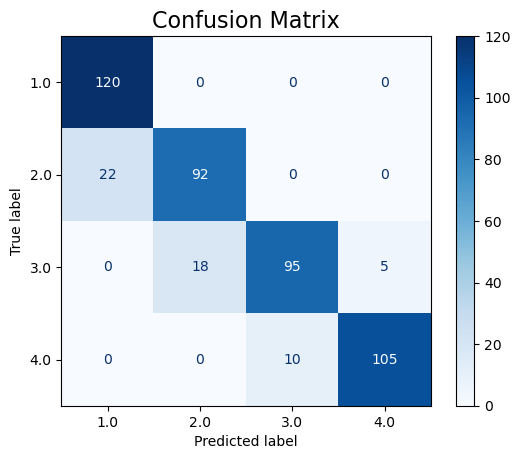

              precision    recall  f1-score   support

         1.0       0.85      1.00      0.92       120
         2.0       0.84      0.81      0.82       114
         3.0       0.90      0.81      0.85       118
         4.0       0.95      0.91      0.93       115

    accuracy                           0.88       467
   macro avg       0.89      0.88      0.88       467
weighted avg       0.88      0.88      0.88       467



In [45]:
# We check for accuracy score against test set

accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# We display the Confusion Matrix for the four classes

cmap = cm.get_cmap('Blues') # specify a colormap
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=cmap)
disp.ax_.set_title('Confusion Matrix', fontsize=16)
plt.show()

# We calculate precision, recall, and F1-score for each class

print(metrics.classification_report(y_test, y_pred))

**Second model: fine-tuned Sequential network with GridSearchCV**

Although our previous model may be good enough, we can actually touch upon many hyperparameters in a sequential network to improve the results. In this case, we will now create a second model and play with different hyperparameters: 

1. ***neurons_1*** : will play with the number of neurons to incorporate in our first hidden layer.
2. ***neurons_2*** : will play with the number of neurons to incorporate in our second hidden layer.
3. ***optimizer*** : will play with the optimizer inside the ```.compile``` method.
4. ***batch_size*** : will play with the size of the batches in each epoch, informing the loss reduction.
5. ***epochs*** : will play with the number of iterations around the whole training dataset in fitting.
6. ***activation_h*** : will play with the different activation functions in the two hidden layers.
    
The reason behind such parameters and the somehow limited number of parameters is the computational time. We tried reducing the parameters to the minimum, but the outcome achieved is still a high runtime with ```n_jobs=-1```. 

***Attention: The expected runtime for this specific model is of 5:23 minutes!***

It is worth mentioning that it is not possible to hyperparameterize without our predictors starting at 0, as the resulting tensor adds an additional predictor that destabilizes the consistency of outputs in the model. The following post details this exact problem (https://stackoverflow.com/questions/56253892/keras-to-categorical-adds-additional-value), with the solution mentioned applied. Therefore, we must bear in mind that predictors will range between 0.0 and 3.0, one value less than the original ```hf_quartile```variable, which does not affect technically our model.

In [46]:
# We define a function that returns the Keras model, with different parameters as function arguments

def create_model(neurons1=64, neurons2=32, optimizer='adam', activation_h="relu"):
    keras_model = Sequential()
    keras_model.add(Dense(neurons1, input_shape=(54,), activation=activation_h)) 
    keras_model.add(Dense(neurons2, activation=activation_h))
    keras_model.add(Dense(4, activation='softmax'))
    keras_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return keras_model

# We create the pipeline with the function as the model

pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler(with_mean=False)),
    ('keras', KerasClassifier(build_fn=create_model, epochs=100, batch_size=64, verbose=0))
])

# We then define the hyperparameter grid to search through the different combinations.

param_grid = {
    'keras__neurons1': [64, 128],
    'keras__neurons2': [32, 64],
    'keras__optimizer': ['adam', 'rmsprop'],
    'keras__batch_size': [32, 64],
    'keras__epochs': [100, 130],
    'keras__activation_h': ['relu', 'tanh']
}

# We then split the data into training and testing sets. We apply here the solution mentioned before,
# one hot encoding y_test to match model's output.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
y_train = y_train - 1
y_test = y_test - 1
y_test_encoded = to_categorical(y_test)

# We instantiate a callback to record history

history = History()

# We then erform grid search over the hyperparameter grid, with cv=3 to avoid high computational cost

grid = GridSearchCV(pipe, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)

# We then fit the model with validation data, and record history

grid_result = grid.fit(X_train, y_train, keras__validation_data=(X_test, y_test_encoded), keras__callbacks=[history])

# We prrint the best hyperparameters and their score, and define a direct access to our best model

print(f'Best score: {grid_result.best_score_:.4f}')
print(f'Best params: {grid_result.best_params_}')
best_model = grid_result.best_estimator_.named_steps['keras']

Fitting 3 folds for each of 64 candidates, totalling 192 fits


/Users/adriatermesberruga/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/Users/adriatermesberruga/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

/Users/adriatermesberruga/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/Users/adriatermesberruga/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

/Users/adriatermesberruga/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/Users/adriatermesberruga/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

/Users/adriatermesberruga/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/Users/adriatermesberruga/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

/Users/adriatermesberruga/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/Users/adriatermesberruga/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

/Users/adriatermesberruga/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/Users/adriatermesberruga/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

/Users/adriatermesberruga/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/Users/adriatermesberruga/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

/Users/adriatermesberruga/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/Users/adriatermesberruga/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

/Users/adriatermesberruga/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/Users/adriatermesberruga/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

/Users/adriatermesberruga/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/Users/adriatermesberruga/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

/Users/adriatermesberruga/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/Users/adriatermesberruga/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

Best score: 0.9329
Best params: {'keras__activation_h': 'tanh', 'keras__batch_size': 64, 'keras__epochs': 130, 'keras__neurons1': 128, 'keras__neurons2': 64, 'keras__optimizer': 'adam'}


15/15 [==============================] - 0s 926us/step


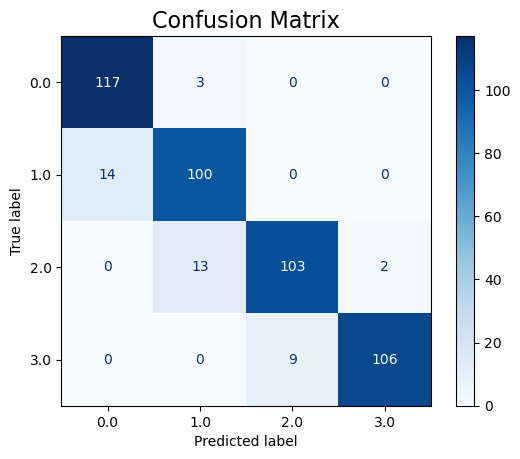

              precision    recall  f1-score   support

         0.0       0.89      0.97      0.93       120
         1.0       0.86      0.88      0.87       114
         2.0       0.92      0.87      0.90       118
         3.0       0.98      0.92      0.95       115

    accuracy                           0.91       467
   macro avg       0.91      0.91      0.91       467
weighted avg       0.91      0.91      0.91       467



In [47]:
# We get the estimators of the best model
best_model = grid_result.best_estimator_

# We then predict the target variable using the best model
y_pred = best_model.predict(X_test)

# We display the Confusion Matrix
cmap = cm.get_cmap('Blues') # specify a colormap
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=cmap)
disp.ax_.set_title('Confusion Matrix', fontsize=16)
plt.show()

# We generate the classification report against holdout test set. We observe the -1 in labels!
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

**Conclusions and final comment**

Up to here, we created 2 different models, hyperparameterizing one of them inside the Scikit-learn wrapper, with generally improved accuracy, precision and recall results. We are aware of the existance of functions like ```plot_loss```and of ```callbacks```to record history in the training and also of the function ```EarlyStopping``` with patience for avoiding overfitting the model, and the usefulness of them.

Team B12 have tried to plot such loss curves for train and test sets (present in the ```validation_data```parameter when fitting the grid), but have been unable after considerable research hours to spot the debugging issue that prompts to only plot the validation curve (cells showing it are below).

Also, considerable issues have arised from the computational runtime. Team B12 is aware of the correction perspective, and that is why hyperparameters are limited, after having seen runtimes of approximately 30 minutes preventing the team to move forward. The cells below show the failed approach: trying to create a simpler model based on the best parameters of the Grid SearchCV, but encountering endlessly the problem of non-matching output shapes which did not allow for the solution to be enhanced.

Overall, considerations of the approach are:

1. It is difficult to actually code a sequential network for a simple tabular data problem. As Jordi stated in class, using tabular data with deep neural networks is like "trying to kill a flie with a gun". The model is complex, and tensors own rules makes it somehow complex to merge with Scikit-learn.


2. A problem with little number of instances makes it difficult to make sense of this architecture. Also, we are sure after browsing the Keras documentation that we just scratched the surface, and that Keras may be a world on its own. The team even spotted on the last day a Keras Pipeline, but for the team sanity, and because of time, we were not able to further develop our approach with it.

Cells below are left just to showcase the intentions showed in case it is interesting for the corrector, as well as to go back in a future occasion for the team.

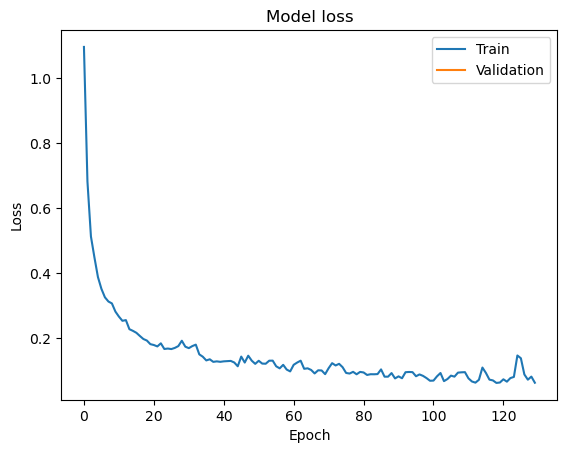

In [48]:
# Effort to plot the loss_curve for both training and test sets (Validation is not plotted, may be an error). 
# After such error repeating many ttimes, the team decided to try to recreate the model in a simpler way.

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [49]:
# We eliminated manually and outside the pipe the missing values in the feature matrix.

for col in X_train.columns:
    mode = X_train[col].mode()[0] 
    X_train[col] = X_train[col].fillna(mode) 
    
for col in X_test.columns:
    mode = X_test[col].mode()[0] 
    X_test[col] = X_test[col].fillna(mode)  

In [50]:
if X_train.isnull().any().any():
    print("The DataFrame X_train has missing values.")
else:
    print("The DataFrame X_train does not have any missing values.")

if X_test.isnull().any().any():
    print("The DataFrame X_test has missing values.")
else:
    print("The DataFrame X_test does not have any missing values.")

The DataFrame X_train does not have any missing values.
The DataFrame X_test does not have any missing values.


In [66]:
#We then scaled our features in a manual way also.

X_train=pipe.fit_transform

ValueError: Invalid shape for y: ()

In [52]:
#We then tried recreating the model by calling the best parameters dictionary, without success for the
#constant output shape mismatch.

early_stopping=EarlyStopping(monitor="val_loss", patience=10)

# Split the data into training and testing sets
y_train = y_train - 1
y_test = y_test - 1
# One-hot encode y_test to match the output shape of the model
y_test_encoded = to_categorical(y_test)

model=Sequential()

model.add(Dense(grid_result.best_params_["keras__neurons1"], input_shape=(54,), 
          activation=grid_result.best_params_["keras__activation_h"]))
model.add(Dense(grid_result.best_params_["keras__neurons2"], 
                activation=grid_result.best_params_["keras__activation_h"]))
model.add(Dense(4, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer=grid_result.best_params_["keras__optimizer"])

h_callback=model.fit(X_train, y_train, epochs=grid_result.best_params_["keras__epochs"], 
          batch_size=grid_result.best_params_["keras__batch_size"],
          validation_data=(X_test, y_test_encoded), callbacks=[early_stopping])

Epoch 1/130


ValueError: in user code:

    File "/Users/adriatermesberruga/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/Users/adriatermesberruga/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/adriatermesberruga/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/Users/adriatermesberruga/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/adriatermesberruga/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "/Users/adriatermesberruga/opt/anaconda3/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/adriatermesberruga/opt/anaconda3/lib/python3.9/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/adriatermesberruga/opt/anaconda3/lib/python3.9/site-packages/keras/losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/adriatermesberruga/opt/anaconda3/lib/python3.9/site-packages/keras/losses.py", line 2004, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/Users/adriatermesberruga/opt/anaconda3/lib/python3.9/site-packages/keras/backend.py", line 5532, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 4) are incompatible
